In [2]:
import keras
from sklearn.preprocessing import MinMaxScaler, Normalizer,StandardScaler
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
import pandas as pd
import pickle
import elf
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [8]:
baseline = 'BH/dz_custom/'
reference = 'MB-pol'
# systems = ['dimers','trimers','128']
# systems = ['monomers','dimers','trimers','64']
# systems = ['monomers','dimers','trimers']
# systems = ['monomers','dimers','trimers']
# systems = ['monomers']
# systems = ['monomers','dimers','trimers','hexamers_embedded_ghost']
systems = ['128_large']
which = 'o'
all_targets = []
all_features = []
for system in systems:
    elfs = elf.utils.hdf5_to_elfs('../data/' + baseline + '/elfs/basis_old_nn/{}_processed.hdf5'.format(system), which)

    angles = np.concatenate([[e.angles for e in e] for e in elfs], axis = 0)
    feat = np.concatenate([[e.value for e in e] for e in elfs], axis = 0 )

    if which == 'h':
        fro, to = 1,3
    else:
        fro, to = 0,1

    tar_baseline= np.genfromtxt('../data/' +baseline + '/' + system + '/forces.dat', delimiter = ',').reshape(-1,3,3)[:,fro:to] 
    tar_reference = np.genfromtxt('../data/' +reference + '/' + system + '/forces.dat', delimiter = ',').reshape(-1,3,3)[:,fro:to]
    targets = tar_reference - tar_baseline
    targets = np.concatenate(targets, axis = 0)
    targets_oriented = np.array(targets)
    for i,_ in enumerate(targets):
        targets_oriented[i] = elf.geom.rotate_vector(targets[i:i+1], angles[i], inverse=True) 
    targets = targets_oriented
    if 'hexamers_embedded' in system:
        if which == 'h':
            feat = np.concatenate([feat[::12],feat[1::12]])
            targets = np.concatenate([targets[::12],targets[1::12]])
        if which == 'o':
            feat = feat[::6]
            targets = targets[::6]
    all_features.append(feat)
    all_targets.append(targets)
feat = np.concatenate(all_features)
targets = np.concatenate(all_targets)

KeyError: "Can't open attribute (can't locate attribute: 'basis')"

In [32]:
nan = np.unique(np.where(np.isnan(feat))[0])
not_nan = np.delete(np.arange(len(feat)),nan, axis=0)
feat = feat[not_nan]
targets = targets[not_nan]

In [33]:
feat_mask = (np.std(feat, axis =0) > 1e-3)
feat = feat[:, feat_mask]

tar = targets
percentile_cutoff = 0.000001
selection = []
for t in tar.T:
    lim1 = np.percentile(t, percentile_cutoff*100)
    lim2 = np.percentile(t, (1 - percentile_cutoff)*100)
    min_lim, max_lim = min(lim1,lim2), max(lim1,lim2)
    selection.append((t > min_lim) & (t < max_lim))

filt = [s1 & s2 & s3 for s1,s2,s3 in zip(*selection)]


feat = feat[filt]
tar = tar[filt]
print(feat.shape)

# scaler = Normalizer()
# scaler.fit(feat)
# feat = scaler.transform(feat)

# pca = PCA(n_components=36)
# feat = pca.fit_transform(feat)

scaler = StandardScaler()
scaler.fit(feat)
feat = scaler.transform(feat)
#     feat = mono_feat
#     tar = mono_targets
#     feat = np.concatenate([mono_feat,dimer_feat], axis = 0)
#     tar = np.concatenate([mono_targets,dimer_targets], axis = 0)
# X_train, X_test, y_train, y_test = train_test_split(feat, 
#                                                     tar,
#                                                     shuffle =True, random_state = 42, test_size = 0.4) 


(9277, 18)


In [34]:
filt_o = np.array(filt)

In [35]:
filt_h = np.array(filt)

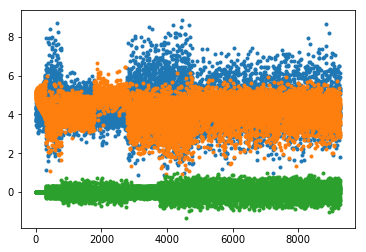

In [36]:
plot(targets, ls ='', marker = '.')

In [37]:
X_train, X_test, y_train, y_test = train_test_split(feat, 
                                                    tar, 
                                                    shuffle =True, random_state = 42, test_size = 0.2)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, 
                                                    y_train, 
                                                    shuffle =True, random_state = 42, test_size = 0.2)

In [38]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers





b = 1e-8
model = Sequential()
s = 16
model.add(Dense(units=s, activation='sigmoid', kernel_regularizer=regularizers.l2(b), input_dim=X_train.shape[1]))
model.add(Dense(units=s, activation='sigmoid', kernel_regularizer=regularizers.l2(b)))
model.add(Dense(units=s, activation='sigmoid', kernel_regularizer=regularizers.l2(b)))
model.add(Dense(units=3, activation='linear'))
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='mean_squared_error',
              optimizer=adam,
              metrics=['accuracy'])



In [39]:
last_train = 1000
last_valid = 1000

for i in range(100):
    model.fit(X_train, y_train, epochs=500, batch_size= 500, verbose=0)
    train_loss = np.sqrt(model.evaluate(X_train, y_train, verbose = 0)[0])
    valid_loss = np.sqrt(model.evaluate(X_valid, y_valid, verbose = 0)[0])
    if train_loss < last_train and valid_loss > last_valid:
        break  #Early stopping
    else:
        last_train = train_loss
        last_valid = valid_loss
    print(train_loss, valid_loss)

0.16872754042074367 0.1717618669392381
0.14846858065711668 0.15243545156641913
0.14227883300497232 0.14680368426169887
0.13843300389460764 0.14510968565156962
0.13578364333904971 0.1445696766822692


KeyboardInterrupt: 

In [40]:
rmd, _ = model.evaluate(X_test, y_test)
np.sqrt(rmd)

1856/1856 [==============================] - 0s 25us/step


0.14591722582041458

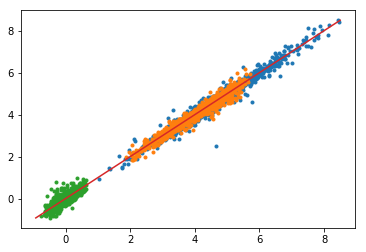

In [41]:
plot(model.predict(X_test), y_test, ls = '', marker = '.')
min_ = np.min(y_test)
max_ = np.max(y_test)
plot([min_, max_],[min_,max_])

In [22]:
model_name = '/nn/pbesz_to_pbedz_hexemb/'

In [21]:
model.save('../../elf_models/models_masked/{}/force_{}'.format(model_name, which.upper()))

In [209]:
with open('../../elf_models/models_masked/{}/scaler_{}'.format(model_name, which.upper()), 'wb') as file:
    pickle.dump(scaler, file)

In [210]:
pd.DataFrame(feat_mask).to_csv('../../elf_models/models_masked/{}/mask_{}'.format(model_name, which.upper()), 
                               index = None, header = None)

In [42]:
baseline = 'PBE_sz'
reference = 'PBE_dz'

which = 'o'
# systems = ['monomers','dimers','trimers']
systems = ['64']
all_targets = []
all_features = []
# model = keras.models.load_model('../../elf_models/models_masked/{}/force_{}'.format(model_name, which.upper()))
# scaler = pickle.load(open('../../elf_models/models_masked/{}/scaler_{}'.format(model_name, which.upper()), 'rb'))
for system in systems:
    elfs = elf.utils.hdf5_to_elfs('../data/' + baseline + '/elfs/basis_old_nn/{}_processed.hdf5'.format(system), which)

    angles = np.concatenate([[e.angles for e in e] for e in elfs], axis = 0)
    feat = np.concatenate([[e.value for e in e] for e in elfs], axis = 0 )

    if which == 'h':
        fro, to = 1,3
    else:
        fro, to = 0,1

    tar_baseline= np.genfromtxt('../data/' + baseline + '/' + system + '/forces.dat', delimiter = ',').reshape(-1,3,3)[:,fro:to] 
    tar_reference = np.genfromtxt('../data/' + reference + '/' + system + '/forces.dat', delimiter = ',').reshape(-1,3,3)[:,fro:to]
    targets = tar_reference - tar_baseline
    targets = np.concatenate(targets, axis = 0)
    targets_oriented = np.array(targets)
    for i,_ in enumerate(targets):
        targets_oriented[i] = elf.geom.rotate_vector(targets[i:i+1], angles[i], inverse=True) 
    targets = targets_oriented
    all_features.append(feat)
    all_targets.append(targets)
feat = np.concatenate(all_features)
targets = np.concatenate(all_targets)
feat = feat[:,feat_mask]
feat = scaler.transform(feat)

{'r_o_o': 1.0, 'r_i_o': 0.05, 'n_rad_o': 2, 'n_l_o': 3, 'gamma_o': 0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_h': 2, 'n_l_h': 2, 'gamma_h': 0}


0.4540094577370822


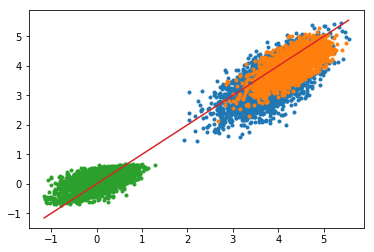

In [43]:
plot(targets, model.predict(feat),ls ='', marker = '.')
plot([np.min(targets), np.max(targets)],[np.min(targets),np.max(targets)])
print(np.sqrt(np.mean((targets -model.predict(feat))**2)))

In [103]:
elfs[0][0].basis

{'r_o_o': 1.5,
 'r_i_o': 0.05,
 'n_rad_o': 2,
 'n_l_o': 3,
 'gamma_o': 0,
 'r_o_h': 2.0}

In [2]:
from ase.io import read, write

read('soome_xyz_file.xyz')